In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './input/plantvillage/'
width=256
height=256
depth=3
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [2]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
		
		
		

In [3]:
image_list, label_list = [], []
try:
    print("Loading images ...")
    root_dir = listdir(directory_root)
    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            
            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")
	

Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


In [4]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

np_image_list = np.array(image_list, dtype=np.float16) / 225.0

print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']
[INFO] Spliting data to train, test


In [5]:
from tensorflow.keras import layers

In [7]:
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding="same",input_shape=inputShape,activation = 'relu' ),
tf.keras.layers.BatchNormalization(axis=chanDim),
tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding="same",activation = 'relu'),
tf.keras.layers.BatchNormalization(axis=chanDim),
tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding="same",activation = 'relu'),
tf.keras.layers.BatchNormalization(axis=chanDim),
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters = 128,kernel_size= (3, 3), padding="same",activation = 'relu'),
tf.keras.layers.BatchNormalization(axis=chanDim),
tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding="same",activation = 'relu'),
tf.keras.layers.BatchNormalization(axis=chanDim),
tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(1024,activation = 'relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(15,activation = 'softmax')
])
model.summary()


#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer='Adam',metrics=["accuracy"])
# train the network
print("[INFO] training network...")

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 85, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        3

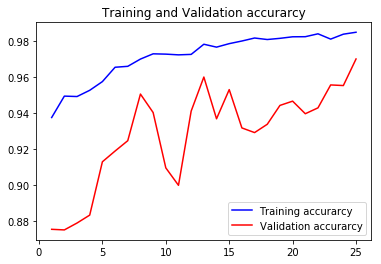

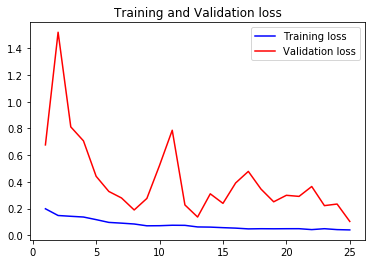

[INFO] Calculating model accuracy
591/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.10300054357035712, 0.97010726]
Test Accuracy: 97.01072573661804


In [154]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(scores)
print(f"Test Accuracy: {scores[1]*100}")


In [156]:
# save the model to disk
print("[INFO] Saving model...")
pickle_save = open("cnn_model.pickel","ab")
pickle.dump(model,pickle_save)
pickle_save.close()

[INFO] Saving model...


TypeError: can't pickle _thread._local objects

In [176]:
saved_model = pickle.dumps(model) 
knn_from_pickle = pickle.loads(saved_model) 

TypeError: can't pickle _thread._local objects

In [173]:
with open ('dekhle.pkl','rb') as f :
    data = pickle.load(f)

EOFError: Ran out of input

In [174]:
data.shape

(2952, 256, 256, 3)

tesing data

In [148]:
t = plt.imread("pepper bell.JPG")
t = cv2.resize(t,(256,256))
t.shape

(256, 256, 3)

(256, 256, 3)
(1, 256, 256, 3)


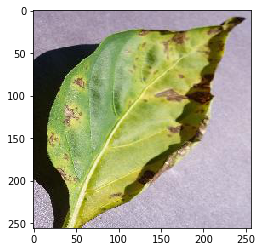

In [149]:
plt.imshow(t)
t = np.array(t,dtype = np.float32)/225.0
print(t.shape)
t = t.reshape(1,256,256,3)
print(t.shape)

In [155]:
ma = model.predict(t)
max_value = np.max(ma) 
index = np.argmax(ma)
label_binarizer.classes_[index]

'Pepper__bell___Bacterial_spot'

In [ ]:
with open("dekhle.pkl","ab") as f:
    pickle.dump(model,f)
from sklearn.externals import joblib
joblib.dump(model,"job_dekhle.pkl")
my = joblib.load('job_dekhle.pkl')
takeout= open("label_transform.pkl","rb")
pickle.load(takeout)
    